<h4>Import required libraries and set required env /global variables</h4>

In [216]:
import os
import sys
import csv

import time
import warnings
import datetime
import random
import pickle
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [68]:
import torch
from torch import nn
import torch.multiprocessing
import torch.distributed as dist
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer

from transformers import AutoModel, AutoModelWithLMHead, AutoModelForCausalLM, pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from accelerate import Accelerator

In [4]:
RANDOM_SEED = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
EVAL_MODEL_1 = "jy46604790/Fake-News-Bert-Detect"
EVAL_MODEL_2 = "winterForestStump/Roberta-fake-news-detector"
BASE_MODEL_1 = "./fakeNews_vanilla"
ADV_MODEL_1 = "./fakeNews_adv"

<h2>Data-preprocessing<h/2>

Visualize individual databases and then combine them

In [110]:
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")
mix_df = pd.read_csv("WELFake_Dataset.csv")

In [111]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [112]:
mix_df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [113]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [114]:
print(len(true_df), len(fake_df), len(mix_df))

21417 23481 72134


Looking at the layout of the datasets, the common features are 'text' and 'title'. Combining these 3 different datasets into a test and train dataset.

WEL_database has their label flipped. So need ot reverse that in the following helper funtion. 

In [115]:
def get_vanilla_datasets():
    true_df = pd.read_csv("True.csv")
    fake_df = pd.read_csv("Fake.csv")
    train_df = pd.read_csv("WELFake_Dataset.csv")

    true_df = true_df.drop(columns=["subject", "date", "title"])
    fake_df = fake_df.drop(columns=["subject", "date", "title"])
    train_df = train_df.drop(columns=["Unnamed: 0", "title"])    

    true_df['label'] = 1
    fake_df['label'] = 0

    combined_df = pd.concat([true_df, fake_df])

    combined_df = combined_df.dropna()
    train_df = train_df.dropna()

    train_df['label'] = train_df["label"] ^ 1 # XOR operation flips 1 and 0

    train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    combined_df = combined_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    split_idx = int(len(train_df) * 0.9)
    val_df = (train_df[split_idx : ]).reset_index(drop=True)
    train_df = (train_df[ : split_idx]).reset_index(drop=True)


    train_df.name = "Vanilla Train"
    val_df.name = "Vanilla Validation"
    combined_df.name = "Vanilla Test"

    return train_df, val_df, combined_df


In [182]:
def get_adversarial_datasets():
    llm_train = pd.read_csv("llm_train.csv")
    llm_test = pd.read_csv("llm_test.csv")

    llm_train = llm_train.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    llm_test = llm_test.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    split_idx = int(len(llm_train) * 0.7)

    llm_val = (llm_train[split_idx : ]).reset_index(drop=True)
    llm_train = (llm_train[: split_idx]).reset_index(drop=True)

    llm_train.name = "Adv-LLM Train"
    llm_val.name = "Adv-LLM Validation"
    llm_test.name = "Adv-LLM Test"

    return llm_train, llm_val, llm_test

def get_adversarial_dataset_v2():
    llm_f2r = pd.read_csv("fake2real.csv")
    llm_r2f = pd.read_csv("real2fake.csv")

    llm_train = pd.concat([llm_f2r, llm_r2f], ignore_index=True)
    llm_train = llm_train.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    llm_train.name = "Adv test dataset v2"

    return llm_train

def get_mix_datasets():

    llm_train, llm_val, llm_test = get_adversarial_datasets()
    van_train, van_val, van_test = get_vanilla_datasets()

    llm_train.drop('text', axis=1, inplace=True)
    llm_val.drop('text', axis=1, inplace=True)
    llm_test.drop('text', axis=1, inplace=True)

    llm_train.rename(columns={'llm-text': 'text'}, inplace=True)
    llm_val.rename(columns={'llm-text': 'text'}, inplace=True)
    llm_test.rename(columns={'llm-text': 'text'}, inplace=True)

    mix_train = pd.concat([llm_train, van_train], ignore_index=True)
    mix_val = pd.concat([llm_val, van_val], ignore_index=True)
    mix_test = pd.concat([llm_test, van_test], ignore_index=True)

    return mix_train, mix_val, mix_test

def get_full_llm_dataset():
    llm_train = pd.read_csv("llm_train.csv")
    llm_test = pd.read_csv("llm_test.csv")

    llm_full = pd.concat([llm_train, llm_test], ignore_index=True)

    return llm_full


In [183]:
llm_train, llm_val, llm_test = get_adversarial_datasets()
van_train, van_val, van_test = get_vanilla_datasets()
mix_train, mix_val, mix_test = get_mix_datasets()

llm_test2 = get_adversarial_dataset_v2()

In [142]:
van_train.head()

,text,label
0,"by Bill Holter, JS Mineset : \nHere we are aga...",0
1,Wow! Moonbeam Johnson addresses three issues h...,0
2,21st Century Wire says Amid great mainstream ...,0
3,A massive global debt write-down of sovereign ...,0
4,WASHINGTON (Reuters) - A U.S. congressional co...,1


In [73]:
llm_train.head()

,text,llm-text,label
0,(Reuters) - The Republican tax overhaul framew...,(Reuters) - The Republican tax overhaul framew...,1
1,"Wednesday, I participated in Facebook’s meetin...","Wednesday, I participated in a meeting between...",1
2,Russia plans to test elements of new nuclear e...,"""Dear valued investors, we have an incredible ...",0
3,MOSCOW (Reuters) - Russia may decide to design...,MOSCOW (Reuters) - Russia may designate any me...,1
4,BAGHDAD (Reuters) - The Iraqi government accus...,BAGHDAD (Reuters) - The Iraqi government accus...,1


In [74]:
mix_train.head()

,text,label
0,(Reuters) - The Republican tax overhaul framew...,1
1,"Wednesday, I participated in a meeting between...",1
2,"""Dear valued investors, we have an incredible ...",0
3,MOSCOW (Reuters) - Russia may designate any me...,1
4,BAGHDAD (Reuters) - The Iraqi government accus...,1


In [66]:
print(f"length of databases : \n {van_train.name} : {len(van_train)} \n {van_val.name} : {len(van_val)} \n {van_test.name} : {len(van_test)}")

length of databases : 
 Vanilla Train : 64885 
 Vanilla Validation : 7210 
 Vanilla Test : 44898


In [67]:
print(f"length of databases : \n {llm_train.name} : {len(llm_train)} \n {llm_val.name} : {len(llm_val)} \n {llm_test.name} : {len(llm_test)}")

length of databases : 
 Adv-LLM Train : 9536 
 Adv-LLM Validation : 1060 
 Adv-LLM Test : 5736


LLM-Stylize articles to generate adversarial input. 

In [18]:
def chunk_dataframe(df, batch_size):
    for start in range(0, len(df), batch_size):
        yield df.iloc[start:start + batch_size]

In [8]:
model_id = "meta-llama/Llama-3.2-3B-Instruct" # better adherence to instructions

pipe = pipeline(
    task="text-generation", 
    model=model_id, 
    model_kwargs={"torch_dtype" : torch.bfloat16}, 
    device_map="auto",
    max_new_tokens=512,
    return_full_text=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def build_prompts(batch):
    messages = []

    real_prompt = "You are a writing AI assistant. Rewrite the provided text with official language. Respond only with the rewritten passage."
    fake_prompt = "You are a writing AI assistant. Rewrite the provided text like a scammer. Respond only with the rewritten passage."

    for _, (_,data) in enumerate(batch.iterrows()):
        sys_message = real_prompt if data['label'] else fake_prompt
        user_message = "Respond only with the rewritten passage. Here is the passage: \n {}. ".format(data['text'])

        message = [
            { "role" : "system", "content" : sys_message},
            { "role" : "user", "content" : user_message}
            ]
        
        messages.append(message)
    return messages

def get_llm_df(responses, batch):

    assert len(responses) == len(batch), "print len of batch and respones is not same"


    llm_responses = []
    for i in range(len(batch)):
        llm_response = responses[i][0]['generated_text']
        llm_responses.append(llm_response)

    llm_stylized_df = pd.DataFrame({
        'text' : batch['text'],
        'llm-text' : llm_responses,
        'label' : batch['label']
    })

    return llm_stylized_df


def process_batch(df, pipe_obj, batch_size):
    results = []
    for batch in chunk_dataframe(df, batch_size):
        msgs = build_prompts(batch)
        responses = pipe_obj(msgs)
        llm_df = get_llm_df(responses, batch)
        break
    return llm_df

<h2>Test a variety of models to evaluate their performance on datasets</h2>

In [119]:
def model_prediction(clf_model, text):
    encoding = clf_model.tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
    output = clf_model.model(**encoding)
    logits = output.logits
    probs = F.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probs, dim=-1)
    predicted_label = predicted_label.item()

    return predicted_label


def establish_performance(model_id, df, debug=False):
    clf = pipeline("text-classification", model=model_id, tokenizer=model_id, device=DEVICE)
    count = 0
    max_len = len(df)
    if debug:
        max_len = 500
    for i in range(max_len):
        try:
            text = df['text'][i]
            res = model_prediction(clf_model=clf, text=text)
            if res == df['label'][i]:
                count += 1
        except Exception as e:
            print(f"Exception = \n {e}")
            print(f"data = \n {df['text'][i]}")

    acc = (count * 100) / max_len
    print("Accuracy of model {} on {} is {}".format(model_id, df.name, acc))
    return acc

<h5>EVAL_MODEL_1 is bert-based-uncased after being fine tuned on val-df and test_df. Performance on those datasets is expected to be much higher.</h5>

In [184]:
establish_performance(EVAL_MODEL_1, van_train, debug=True)
establish_performance(EVAL_MODEL_1, llm_train)
establish_performance(EVAL_MODEL_1, llm_val)
establish_performance(EVAL_MODEL_1, llm_test)
establish_performance(EVAL_MODEL_1, llm_test2)

Accuracy of model jy46604790/Fake-News-Bert-Detect on Vanilla Train is 85.2
Accuracy of model jy46604790/Fake-News-Bert-Detect on Adv-LLM Train is 86.77685950413223
Accuracy of model jy46604790/Fake-News-Bert-Detect on Adv-LLM Validation is 88.57142857142857
Accuracy of model jy46604790/Fake-News-Bert-Detect on Adv-LLM Test is 100.0
Accuracy of model jy46604790/Fake-News-Bert-Detect on Adv test dataset v2 is 51.0


51.0

In [185]:
establish_performance(EVAL_MODEL_2, van_train, debug=True)
establish_performance(EVAL_MODEL_2, llm_train)
establish_performance(EVAL_MODEL_2, llm_val)
establish_performance(EVAL_MODEL_2, llm_test)
establish_performance(EVAL_MODEL_2, llm_test2)

Accuracy of model winterForestStump/Roberta-fake-news-detector on Vanilla Train is 70.8
Accuracy of model winterForestStump/Roberta-fake-news-detector on Adv-LLM Train is 68.59504132231405
Accuracy of model winterForestStump/Roberta-fake-news-detector on Adv-LLM Validation is 74.28571428571429
Accuracy of model winterForestStump/Roberta-fake-news-detector on Adv-LLM Test is 83.57664233576642
Accuracy of model winterForestStump/Roberta-fake-news-detector on Adv test dataset v2 is 33.75


33.75

<h2> Finetune BERT </h2>

In [75]:
def finetune_bert_base(model_name, train, val, num_epochs=1):
    train_dataset = Dataset.from_pandas(train)
    val_dataset = Dataset.from_pandas(val)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True)

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)

    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',          
        evaluation_strategy="epoch",     
        learning_rate=2e-5,              
        per_device_train_batch_size=8,   
        per_device_eval_batch_size=8,    
        num_train_epochs=num_epochs,              
        weight_decay=0.01,               
        logging_dir='./logs',            
        logging_steps=10,                
        save_strategy="epoch",
        load_best_model_at_end=True,
        no_cuda=False,
        ddp_timeout = 120
    )

    trainer = Trainer(
        model=model,                         
        args=training_args,                  
        train_dataset=train_dataset,         
        eval_dataset=val_dataset,           
        tokenizer=tokenizer,                 
    )

    trainer.train()

    model_path = "./" + model_name
    trainer.save_model(model_path)

Train model

In [ ]:
# finetune_bert_base(model_name="fakeNews_vanilla", train=van_train, val=van_val)

In [86]:
# finetune_bert_base(model_name="fakeNews_adv", train=mix_train, val=mix_val)

Map:   0%|          | 0/74421 [00:00<?, ? examples/s]

Map:   0%|          | 0/8270 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/grads/a/atkulkarni/MIPS/mips/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_3263990/3747646370.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.043900,0.022592


Saving model

In [77]:
def get_predictions(model_name, df, data_col="text"):

    model_path = "./" + model_name
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
    )

    df['text'] = df[data_col]
    test_dataset = Dataset.from_pandas(df)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True)

    tokenized_dataset = test_dataset.map(preprocess_function, batched=True)

    predictions = trainer.predict(tokenized_dataset)
    predicted_logits = predictions.predictions
    probabilities = torch.sigmoid(torch.tensor(predicted_logits))
    predicted_labels = (probabilities >= 0.5).int()

    predicted_labels = predicted_labels.argmax(axis=1).numpy()

    return predictions, predicted_labels

def display_eval_metrics(pred_labels, df):
    true_labels = df["label"].values

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [78]:
vanilla_predictions, vanilla_pred_labels = get_predictions("fakeNews_vanilla", van_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/44898 [00:00<?, ? examples/s]

In [79]:
display_eval_metrics(vanilla_pred_labels, van_test)

Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9999, F1 Score: 0.9998


In [145]:
llm_predictions, llm_pred_labels = get_predictions("fakeNews_vanilla", llm_test, data_col="llm-text")

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/548 [00:00<?, ? examples/s]

In [146]:
display_eval_metrics(llm_pred_labels, llm_test)

Accuracy: 0.8339, Precision: 0.7375, Recall: 0.9921, F1 Score: 0.8460


In [147]:
llm_full = get_full_llm_dataset()
llm_full_predictions, llm_full_pred_labels = get_predictions("fakeNews_vanilla", llm_full, data_col="llm-text")
display_eval_metrics(llm_full_pred_labels, llm_full)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/895 [00:00<?, ? examples/s]

Accuracy: 0.8402, Precision: 0.7412, Recall: 0.9900, F1 Score: 0.8477


In [186]:
van_adv_predictions, van_adv_pred_labels = get_predictions("fakeNews_adv", van_test, data_col="text")
display_eval_metrics(van_adv_pred_labels, van_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/44898 [00:00<?, ? examples/s]

Accuracy: 0.9996, Precision: 0.9992, Recall: 1.0000, F1 Score: 0.9996


In [148]:
llm_adv_predictions, llm_adv_pred_labels = get_predictions("fakeNews_adv", llm_test, data_col="llm-text")
display_eval_metrics(llm_adv_pred_labels, llm_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/548 [00:00<?, ? examples/s]

Accuracy: 0.9982, Precision: 1.0000, Recall: 0.9960, F1 Score: 0.9980


In [149]:
llm_full = get_full_llm_dataset()
llm_full_adv_predictions, llm_full_adv_pred_labels = get_predictions("fakeNews_adv", llm_full, data_col="llm-text")
display_eval_metrics(llm_full_adv_pred_labels, llm_full)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/895 [00:00<?, ? examples/s]

Accuracy: 0.9989, Precision: 1.0000, Recall: 0.9975, F1 Score: 0.9988


<h2>Cosine Similarity of LLM-articles and OG-articles</h2>

In [156]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_cosine_similarity(article_1, article_2):
    embeddings_1 = model.encode([article_1])
    embeddings_2 = model.encode([article_2])
    
    similarity = cosine_similarity(embeddings_1, embeddings_2)
    
    return similarity[0][0]

llm_full = get_full_llm_dataset()

In [157]:
llm_full.head()

,text,llm-text,label
0,Supreme Court Justice Clarence Thomas is the e...,"Here's the rewritten passage, infused with a s...",0
1,"Hillary Clinton, on her campaign plane, respon...","""ATTENTION ALL VOTERS! We've just received wor...",0
2,Wednesday on Fox News Channel’s “America’s New...,"On Wednesday, Senator Rand Paul appeared on Fo...",1
3,WASHINGTON (Reuters) - President Donald Trump ...,WASHINGTON (Reuters) - U.S. President Donald T...,1
4,Ever since Donald Trump failed his test of mor...,Here's the rewritten passage:\n\nYou won't bel...,0


In [158]:

llm_full['similarity'] = llm_full.apply(lambda row: get_cosine_similarity(row['text'], row['llm-text']), axis=1)

In [174]:
llm_full['pred_label'] = llm_full_pred_labels

In [175]:
llm_full.head()

,text,llm-text,label,similarity,pred_label
0,Supreme Court Justice Clarence Thomas is the e...,"Here's the rewritten passage, infused with a s...",0,0.617596,1
1,"Hillary Clinton, on her campaign plane, respon...","""ATTENTION ALL VOTERS! We've just received wor...",0,0.649714,0
2,Wednesday on Fox News Channel’s “America’s New...,"On Wednesday, Senator Rand Paul appeared on Fo...",1,0.806809,1
3,WASHINGTON (Reuters) - President Donald Trump ...,WASHINGTON (Reuters) - U.S. President Donald T...,1,0.976375,1
4,Ever since Donald Trump failed his test of mor...,Here's the rewritten passage:\n\nYou won't bel...,0,0.582429,0


(array([  6.,   5.,   8.,   6.,  11.,  32.,  78., 175., 186., 388.]),
 array([-0.03466903,  0.0684705 ,  0.17161003,  0.27474958,  0.3778891 ,
         0.48102862,  0.58416814,  0.68730766,  0.79044724,  0.89358675,
         0.99672627]),
 <BarContainer object of 10 artists>)

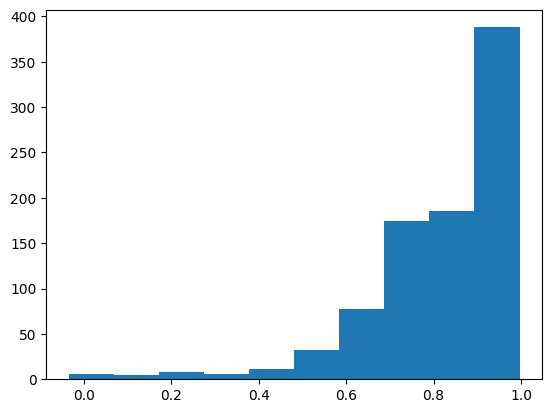

In [176]:
plt.hist(llm_full['similarity'].to_numpy())

In [177]:
temp = llm_full[["label", "pred_label", "similarity"]]
temp2 = llm_full[["label", "pred_label", "similarity"]]

In [178]:
adv_incorrect = temp[temp['label'] != temp['pred_label']]
adv_correct = temp2[temp2['label'] == temp2['pred_label']]

(array([ 1.,  2.,  2.,  2.,  5.,  9., 30., 48., 38.,  6.]),
 array([0.15328267, 0.23538166, 0.31748065, 0.39957964, 0.48167863,
        0.56377763, 0.64587665, 0.72797561, 0.81007463, 0.89217359,
        0.97427261]),
 <BarContainer object of 10 artists>)

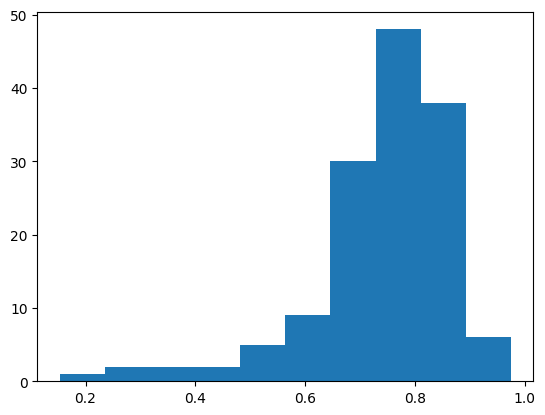

In [180]:
plt.hist(adv_incorrect['similarity'])

(array([  6.,   4.,   6.,   5.,   8.,  25.,  60., 121., 135., 382.]),
 array([-0.03466903,  0.0684705 ,  0.17161003,  0.27474958,  0.3778891 ,
         0.48102862,  0.58416814,  0.68730766,  0.79044724,  0.89358675,
         0.99672627]),
 <BarContainer object of 10 artists>)

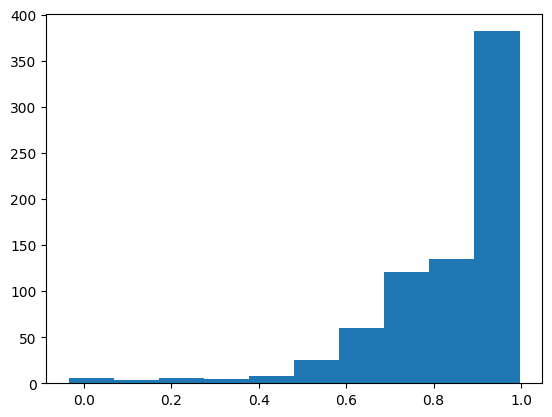

In [187]:
plt.hist(adv_correct['similarity'])

In [190]:
llm_full.shape

(895, 5)

In [191]:
og_real = llm_full[llm_full["label"] == 0]
og_fake = llm_full[llm_full["label"] == 1]

In [194]:
og_real.shape, og_fake.shape

((493, 5), (402, 5))

In [195]:
def display_eval_metrics_v2(pred_labels, true_labels):

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [197]:
display_eval_metrics_v2(og_real["pred_label"].values, og_real["label"].values)

Accuracy: 0.7181, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


/home/grads/a/atkulkarni/MIPS/mips/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [203]:
display_eval_metrics_v2(og_fake["pred_label"].values, og_fake["label"].values)

Accuracy: 0.9900, Precision: 1.0000, Recall: 0.9900, F1 Score: 0.9950


In [226]:
#llm_full_predictions 
y_true = llm_full["label"].values
y_scores_adv = torch.sigmoid(torch.tensor(llm_full_adv_predictions.predictions))
y_scores_pos_adv = y_scores_adv[:, 1].numpy()

In [227]:
y_scores_van = torch.sigmoid(torch.tensor(llm_full_predictions.predictions))
y_scores_pos_van = y_scores_van[:, 1].numpy()

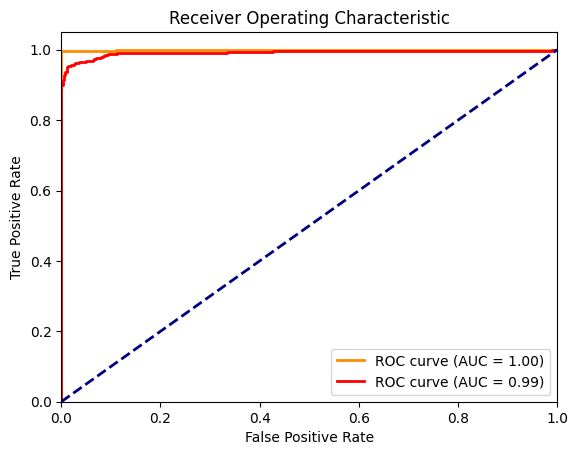

In [233]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores_pos_adv)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, thresholds2 = roc_curve(y_true, y_scores_pos_van)
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()